In [1]:
import numpy as np
import pandas as pd

import pickle

import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

print(pd.__version__)

1.4.2


In [2]:
def get_bodies_data():    
    
    data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

    with open(f'{data_dir}df_od_coordinates.pkl', 'rb') as file:
        bodies_df = pickle.load(file)

    # correcting that one in manhatten
    bodies_df.loc[bodies_df['longitude'] == bodies_df['longitude'].min(), 'latitude'] = bodies_df.loc[bodies_df['longitude'] == bodies_df['longitude'].min(), 'latitude_p']
    bodies_df.loc[bodies_df['longitude'] == bodies_df['longitude'].min(), 'longitude'] = bodies_df.loc[bodies_df['longitude'] == bodies_df['longitude'].min(), 'latitude_p']

    # correcting those with wrong time stamp
    bodies_df.loc[bodies_df['date created'] == '00000000', 'date created'] = np.nan

    # create ythe date time date
    bodies_df['date'] = pd.to_datetime(bodies_df['date created'], format='%Y%m%d', exact = False)

    # Create location annotation dummy
    annotation_mask = (bodies_df['longitude'].notna()) & (bodies_df['latitude'].notna())
    bodies_df['location_annot'] = annotation_mask * 1 

    return(bodies_df)

In [3]:
bodies_df = get_bodies_data()

In [4]:
# you need a dummy regarding wheter the location is infered.

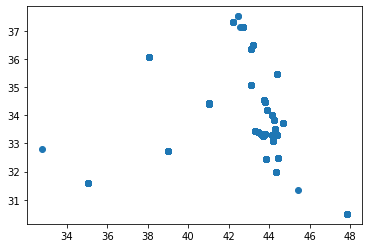

In [5]:
x = bodies_df[bodies_df['location_annot'] == 1]['longitude']
y = bodies_df[bodies_df['location_annot'] == 1]['latitude']

plt.scatter(x,y)
plt.show()

In [49]:
annotated = bodies_df.loc[bodies_df['location_annot'] == 1,'date'].values.reshape(-1, 1)
annotated_location = bodies_df.loc[bodies_df['location_annot'] == 1, ['longitude', 'latitude']]

neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(annotated)

non_annotated = bodies_df.loc[bodies_df['location_annot'] == 0,'date'].values.reshape(-1, 1)
non_annotated_img_id = bodies_df.loc[bodies_df['location_annot'] == 0,'img_id'] # to merge back
distance, preds = neigh.kneighbors(non_annotated)
distance_days = pd.to_timedelta(distance.reshape(-1,)) # from nano seconds to days

In [73]:
non_annotated_df = pd.DataFrame({'img_id' : non_annotated_img_id, 'distance_days' : distance_days, 'pred_idx' : preds.reshape(-1,)})

In [74]:
non_annotated_df

,img_id,distance_days,pred_idx
0,JS116733,0 days,184
1,JS135838,0 days,906
2,JS103079,0 days,582
3,JS46373,0 days,8226
4,JS45383,0 days,7896
...,...,...,...
133569,JS66284,23 days,1539
133570,JS20288,0 days,16019
133571,JS83118,1 days,8628
133572,JS100974,0 days,36


In [75]:
annotated_location['pred_idx'] = annotated_location.reset_index().index

In [76]:
annotated_location

,longitude,latitude,pred_idx
133574,44.378799,33.302431,0
133575,44.378799,33.302431,1
133576,44.378799,33.302431,2
133577,44.378799,33.302431,3
133578,44.378799,33.302431,4
...,...,...,...
152430,44.152789,34.001313,18856
152431,44.152789,34.001313,18857
152432,44.152789,34.001313,18858
152433,44.152789,34.001313,18859


In [77]:
new_annotated_df = non_annotated_df.merge(right = annotated_location ,how='left', on= 'pred_idx')

In [78]:
new_annotated_df

,img_id,distance_days,pred_idx,longitude,latitude
0,JS116733,0 days,184,44.378799,33.302431
1,JS135838,0 days,906,44.378799,33.302431
2,JS103079,0 days,582,44.378799,33.302431
3,JS46373,0 days,8226,41.037860,34.427567
4,JS45383,0 days,7896,41.046437,34.390889
...,...,...,...,...,...
133569,JS66284,23 days,1539,44.378799,33.302431
133570,JS20288,0 days,16019,44.378799,33.302431
133571,JS83118,1 days,8628,43.299922,33.425986
133572,JS100974,0 days,36,44.378799,33.302431


In [79]:
brandnew = bodies_df.merge(right = new_annotated_df, how = 'left', on = 'img_id')

In [80]:
brandnew

,person_mean,person_median,person_fasterR50,person_fasterR101,person_fasterX101,person_retinaR50,person_retinaR101,child_mean,child_median,child_retinaR50,...,latitude_x,longitude_x,latitude_p,longitude_p,date,location_annot,distance_days,pred_idx,longitude_y,latitude_y
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,2008-12-27,0,0 days,184.0,44.378799,33.302431
1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,2009-09-01,0,0 days,906.0,44.378799,33.302431
2,1.6,2.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,2007-10-12,0,0 days,582.0,44.378799,33.302431
3,2.8,3.0,2.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,2005-11-20,0,0 days,8226.0,41.037860,34.427567
4,1.8,2.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,2005-11-15,0,0 days,7896.0,41.046437,34.390889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152436,0.6,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,34.001313,44.152789,34.376222,43.64465,2004-01-14,1,NaT,NaN,NaN,NaN
152437,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,34.001313,44.152789,34.376222,43.64465,2004-01-15,1,NaT,NaN,NaN,NaN
152438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.001313,44.152789,34.376222,43.64465,2004-01-15,1,NaT,NaN,NaN,NaN
152439,4.8,5.0,5.0,5.0,5.0,5.0,4.0,1.5,1.5,2.0,...,34.001313,44.152789,34.376222,43.64465,2004-01-14,1,NaT,NaN,NaN,NaN


In [66]:
bodies_df.loc[3:4,'date'].values.reshape(-1, 1)

array([['2005-11-20T00:00:00.000000000'],
       ['2005-11-15T00:00:00.000000000']], dtype='datetime64[ns]')

In [83]:
td_list = [pd.Timedelta(neigh.kneighbors(non_annotated)[0][i].item()) for i in range(2)]

In [85]:
td_list[0].days

0

In [92]:
annotated_location

,longitude,latitude
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN


So create a dummy for wheter or not there is a location
then train a knn on the sample with locations
then infere to the sample without location.

In [35]:
samples = [[0., 0., 0.], [0., .5, 0.], [1., 1., .5]]
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(samples)
print(neigh.kneighbors([[1., 1., 0.]]))

(array([[0.5]]), array([[2]]))
